In [1]:
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource, output_file
from bokeh.models.tools import HoverTool, BoxSelectTool, BoxZoomTool, PanTool, WheelZoomTool, SaveTool, ResetTool
from bokeh.models.tickers import FixedTicker
from bokeh.models import Panel, Range1d, LinearAxis
import os
import pandas as pd
import numpy as np
from math import pi
from copy import deepcopy

%matplotlib inline

os.chdir('/Users/Kimberly/Documents/projects/ecoli_promoters/endo/bokeh_viz')

NEW_MIN = 1
NEW_MAX = 1000

In [2]:
output_notebook()

Loading BokehJS ...

## Data Sources ##

### In-House ###

- endogenous TSS library in M9
- active endo TSS scramble library
- fragment data in LB and M9
- peak tiling library

### External ###

- TSS strength data from Wanner and Storz
- RNA-seq data from Wanner and Storz
- RegulonDB gene annotation


### Wishlist ###

- box to enter genomic range
- search box to enter gene

**What determines y-axis?**
- fragment pile-up, always present


- show arrow for TSS. Height corresponds to strength in our assay. Show information from three external sources: hover over arrow to display strength in our assay, strength in Storz, if it was detected in Wanner, if it was annotated in RegulonDB

In [3]:
# endo TSS expression
endo_tss_lb = pd.read_table('../processed_data/endo_tss/lb/rLP5_Endo2_expression.txt',
                           sep=' ')

# LB genomic shearing fragment pileup
frag_lb_plus = pd.read_table('../processed_data/frag_peak_calling/lb/plus_frag_pileup.wig',
                            sep='\t', skiprows=1, names=['position', 'expression'])

frag_lb_minus = pd.read_table('../processed_data/frag_peak_calling/lb/minus_frag_pileup.wig',
                            sep='\t', skiprows=1, names=['position', 'expression'])

# M9 minimal genomic shearing fragment pileup
frag_m9_plus = pd.read_table('../processed_data/frag_peak_calling/m9/plus_frag_pileup_M9.wig',
                            sep='\t', skiprows=1, names=['position', 'expression'])

frag_m9_minus = pd.read_table('../processed_data/frag_peak_calling/m9/minus_frag_pileup_M9.wig',
                            sep='\t', skiprows=1, names=['position', 'expression'])


In [4]:
frag_plus_pileup = frag_lb_plus.merge(frag_m9_plus, on='position', how='outer', suffixes=['_lb', '_m9'])
frag_plus_pileup.columns = ['position', 'LB', 'M9']
frag_minus_pileup = frag_lb_minus.merge(frag_m9_minus, on='position', how='outer', suffixes=['_lb', '_m9'])
frag_minus_pileup.columns = ['position', 'LB', 'M9']

frag_plus_pileup = pd.melt(frag_plus_pileup, id_vars=['position'], value_vars=['LB', 'M9'],
             var_name='condition', value_name='expression')
frag_minus_pileup = pd.melt(frag_minus_pileup, id_vars=['position'], value_vars=['LB', 'M9'],
             var_name='condition', value_name='expression')



In [5]:
frag_plus_pileup.head()

,position,condition,expression
0,2,LB,0.0
1,3,LB,0.0
2,4,LB,0.0
3,5,LB,0.0
4,6,LB,0.0


In [6]:
def norm_pileup(pileup):
    # exclude data below median expression. However, for graphing we need a continuous line
    # for all positions. We will set all data below median to the median value, and then scale
    # data so minimum value is 1. On log-scale, log(1) = 0 so any data <= median will be set to
    # zero on plot
    median = np.median(pileup.expression)
    norm_pileup = deepcopy(pileup)
    norm_pileup.expression = np.where(pileup.expression <= median,
                                     median, pileup.expression)
    scalar = 1.0/median
    norm_pileup.expression = norm_pileup.expression * scalar
    # make sure everything is equal to 1, due to decimal multiplication some may be 0.9999
    norm_pileup.expression = np.where(norm_pileup.expression < 1,
                                     1, norm_pileup.expression)
    return norm_pileup
    

In [7]:
def min_max_scale(expression, new_min, new_max, max_value=None, median_norm=None):

    if max_value:
        # cap value at max so the scaling won't be skewed
        expression = np.where(expression > max_value, max_value, expression)

    if median_norm:
        # filter out values below median by setting to zero
        expression = np.where(expression <= median_norm, 0, expression)

    # first min-max normalize to [0, 1]
    min_exp = min(expression)
    max_exp = max(expression)

    norm = (expression - min_exp) / float(max_exp - min_exp)
    # if negative, set to 0

    norm_scaled = (norm * (new_max - new_min)) + new_min

    return norm_scaled


In [9]:
global frag_plus_pileup_norm
global frag_minus_pileup_norm

new_min = 1
new_max = 100
frag_plus_pileup_norm = deepcopy(frag_plus_pileup)
frag_plus_pileup_norm.expression = min_max_scale(frag_plus_pileup_norm.expression, new_min, new_max,
                                                median_norm=np.median(frag_plus_pileup_norm.expression))
frag_minus_pileup_norm = deepcopy(frag_minus_pileup)
frag_minus_pileup_norm.expression = min_max_scale(frag_minus_pileup_norm.expression, new_min, new_max,
                                                 median_norm=np.median(frag_minus_pileup_norm.expression))



In [10]:
# create colors for each condition and strand
global colors
colors = pd.DataFrame({'condition' : ['LB', 'LB', 'M9', 'M9'],
                      'strand' : ['+', '-', '+', '-'],
                      'color' : ['#8daec9', '#edac80', '#528ecb', '#ef8137']})

In [11]:
def make_pileup_dataset(conditions, start, end, colors, log_transform=True):
    
    # subset relevant condition, conditions must be list
    plus_pileup_subset = frag_plus_pileup_norm[(frag_plus_pileup_norm.condition.isin(conditions)) &
                                         (frag_plus_pileup_norm.position.isin(range(start,end)))]
    
    minus_pileup_subset = frag_minus_pileup_norm[(frag_minus_pileup_norm.condition.isin(conditions)) &
                                           (frag_minus_pileup_norm.position.isin(range(start,end)))]
    
    plus_pileup_subset = plus_pileup_subset.merge(colors[colors.strand == '+'], on='condition', how='left')
    minus_pileup_subset = minus_pileup_subset.merge(colors[colors.strand == '-'], on='condition', how='left')
    
    # patch accepts list of lists, make one list for each combination of strand and condition
    # x-axis position will be same for every condition and strand, define coordinates for edges at the top (pileup line) and the 
    position_unique = plus_pileup_subset.sort_values('position').position.unique()
    position = np.hstack((position_unique, position_unique[::-1]))
    # bottom edge along zero (positions in reverse to create closed shape)
    bottom_edge = np.zeros(len(position))
    # take negative of reverse coverage to display on graph
    counts = []
    position_all = []
    condition_colors = []
    for condition in conditions:
        # plus strand
        position_all.append(position)
        if log_transform:
            counts.append(np.hstack((np.log10(plus_pileup_subset.expression[plus_pileup_subset.condition == condition]),
                               bottom_edge)))
        else:
            counts.append(np.hstack((plus_pileup_subset.expression[plus_pileup_subset.condition == condition],
                                   bottom_edge)))
        condition_colors.append(colors.color[(colors.condition == condition) & (colors.strand == '+')].to_string(index=False))
        
        # minus strand
        position_all.append(position)
        if log_transform:
            counts.append(np.hstack((-np.log10(minus_pileup_subset.expression[minus_pileup_subset.condition == condition]),
                               bottom_edge)))
        else:
            counts.append(np.hstack((-minus_pileup_subset.expression[minus_pileup_subset.condition == condition],
                                   bottom_edge)))
        condition_colors.append(colors.color[(colors.condition == condition) & (colors.strand == '-')].to_string(index=False))
    
    patches_src = pd.DataFrame({'position' : position_all, 
                               'count' : counts,
                               'color' : condition_colors})    
    
    return ColumnDataSource(patches_src)

In [13]:
conditions = ['LB']
# start = 2238500 - 300
# end = 2238500 + 300
start = 450000
end = 455000
src = make_pileup_dataset(conditions, start, end, colors)

In [14]:
def make_region_plot(src, html_output=None):
    
    if html_output:
        output_file(html_output)
    else:
        output_notebook(hide_banner=True)
    
    # flatten list of lists in count column of src, find max value of absolute expression
    count_range = max(map(abs, [x for count in src.data['count'] for x in count]))
    
    # draw blank figure of correct size with tools
    p = figure(y_range=(-count_range, count_range), plot_width=900, plot_height=500, 
               tools=[BoxSelectTool(), BoxZoomTool(), PanTool(), WheelZoomTool(), 
                      SaveTool(), ResetTool()])
    
    # format axis and colors
    p.xaxis.axis_label = 'position'
    p.xaxis.major_label_orientation = pi/4
    p.xaxis[0].formatter.use_scientific = False
    p.xaxis[0].ticker=FixedTicker(ticks=range(start, end, 100))
    p.yaxis.axis_label = 'log normalized expression (RNA/DNA)'
        
    p.patches(source=src, xs='position', ys='count', fill_color='color', line_color=None, alpha=0.50)
        
    return p
        

In [15]:
fig = make_region_plot(src)
show(fig)

Now, let's make it so we can check which conditions we want to see on a graph.

In [16]:
def update_region_plot(attr, old, new):
    
    # get list of conditions for graph
    conditions_to_plot = [condition_selection.labels[i] for i in condition_selection.active]
    
    # get selected position, value for range slider is tuple (start, end)
    position_start = position_select.value[0]
    position_end = position_select.value[1]
    
    # make new subset based on selected conditions
    new_src = make_pileup_dataset(conditions_to_plot, position_start, position_end, colors)
    
    # update source used in patch glyphs
    src.data.update(new_src.data)
    

In [15]:
# from bokeh.models.widgets import CheckboxGroup

# conditions = ['LB', 'M9']

# condition_selection = CheckboxGroup(labels=conditions, active = [0])

# # link change in selected buttons to update function
# condition_selection.on_change('active', update_region_plot)

# # RangeSlider to change positions of region
# from bokeh.models.widgets import RangeSlider

# position_select = RangeSlider(start = 2238500 - 300, end = 2238500 + 300,
#                           value = (2238500 - 300, 2238500 + 300),
#                           step = 100, title = 'genomic position')

# # update plot when value is changed
# position_select.on_change('value', update_region_plot)

# # combine all elements onto one page by defining layout

# from bokeh.layouts import column, row, WidgetBox
# from bokeh.models import Panel
# from bokeh.models.widgets import Tabs

# # put controls in single element
# controls = WidgetBox(condition_selection, position_select)

# # create row layout
# layout = row(controls, p)

# # make tab with layout
# tab = Panel(child=layout, title = 'Genomic fragment shearing pileup')
# tabs = Tabs(tabs=[tab])

In [17]:
# let's import the genes and figure out how to plot them
genes = pd.read_table('U00096.2_genes_clean.bed', sep = '\t', header = None,
                      names=['chrom', 'start', 'end', 'name', 'score', 'strand', 
                            'thick_start', 'thick_end', 'item_rgb', 'block_count',
                            'block_sizes', 'block_start'])

# drop unnecessary columns, simplify name
genes = genes[['start', 'end', 'name', 'strand']]
genes.name = [x.split(':')[1] for x in genes.name.tolist()]
genes.head()

,start,end,name,strand
0,189,255,thrL,+
1,336,2799,thrA,+
2,2800,3733,thrB,+
3,3733,5020,thrC,+
4,5233,5530,yaaX,+


In [18]:
def make_region_genes(genes, start, end):
    # grab genes within coordinates, with buffer of 100bp
    start_buffer = start - 100
    end_buffer = end + 100
    region_genes = genes[(genes.start >= start_buffer) & (genes.end <= end_buffer)]

    # center is midpoint of gene
    gene_center = region_genes.start + abs(region_genes.end - region_genes.start)/2.0
    gene_center = gene_center.tolist()
    gene_color = '#e2b306'
    gene_width = region_genes.end - region_genes.start
    gene_width = gene_width.tolist()

    src_gene = ColumnDataSource(data=dict(
    gene_center = gene_center,
    # y-center is on x-axis, i.e y = 0
    gene_center_y = np.zeros(len(region_genes)),
    gene_color = [gene_color] * len(region_genes),
    gene_width = gene_width,
    # set center of triangle to start or end depending on strand
    tri_x = [region_genes.end.iloc[i] if region_genes.strand.iloc[i] == '+' else region_genes.start.iloc[i] \
           for i in range(len(region_genes))],
    angle = [-90 if strand == '+' else 90 for strand in region_genes.strand],
    gene_name = region_genes.name.tolist()))
    
    return src_gene
    

In [19]:
src_gene = make_region_genes(genes, start, end)
src_gene.data

{'angle': [90, 90, -90],
 'gene_center': [452031.0, 453101.5, 453854.0],
 'gene_center_y': array([0., 0., 0.]),
 'gene_color': ['#e2b306', '#e2b306', '#e2b306'],
 'gene_name': ['ampG', 'yajG', 'bolA'],
 'gene_width': [1476, 579, 318],
 'tri_x': [451293, 452812, 454013]}

In [20]:
def make_gene_plot(src_gene, p_region):
    '''
    p_region is object returned from make_region_plot() which has the patches already plotted
    '''
    
    p_region.rect(x='gene_center', y='gene_center_y', width='gene_width',
                 color='gene_color', height=10, height_units='screen', 
                  alpha=0.75, source=src_gene)
    p_region.triangle(x='tri_x', y=0, size=20, angle='angle', angle_units='deg',
                     fill_color='gene_color', line_color=None, alpha=0.75, source=src_gene)
    p_region.text(x='gene_center', y='gene_center_y', text='gene_name', text_color='black',
          text_align='center', text_baseline='middle', text_font_size='10pt', source=src_gene)
    
    return p_region

In [21]:
fig_gene = make_gene_plot(src_gene, fig)
show(fig_gene)

Let's try to combine all the plotting into one function.

In [22]:
def make_region_plot(src, src_gene):
    '''
    Construct pileup plot based on src
    '''

    # output_file(html_output)

    # flatten list of lists in count column of src, find max value of absolute expression
    count_range = max(map(abs, [x for count in src.data['count'] for x in count]))
    
    # draw blank figure of correct size with tools
    p = figure(y_range=(-count_range, count_range), plot_width=900, plot_height=700, 
               tools=[BoxSelectTool(), BoxZoomTool(), PanTool(), WheelZoomTool(), 
                      SaveTool(), ResetTool()],
               toolbar_location='above')
    
    # format axis and colors
    p.xaxis.axis_label = 'position'
    p.xaxis.major_label_orientation = pi/4
    p.xaxis[0].formatter.use_scientific = False
    # p.xaxis[0].ticker=FixedTicker(ticks=range(start, end, 100))
    p.yaxis.axis_label = 'log normalized expression (RNA/DNA)'
        
    p.patches(source=src, xs='position', ys='count', fill_color='color', line_color=None, alpha=0.50)

    # plot genes
    p.rect(x='gene_center', y='gene_center_y', width='gene_width',
                 color='gene_color', height=10, height_units='screen', 
                  alpha=0.75, source=src_gene)
    p.triangle(x='tri_x', y=0, size=20, angle='angle', angle_units='deg',
                     fill_color='gene_color', line_color=None, alpha=0.75, source=src_gene)
    p.text(x='gene_center', y='gene_center_y', text='gene_name', text_color='black',
          text_align='center', text_baseline='middle', text_font_size='10pt', source=src_gene)
    
    return p

In [23]:
p = make_region_plot(src, src_gene)
show(p)

Great! Now let's add arrows for the TSS. The height will correspond to TSS strength. It's too difficult to graph in terms of the normalized fragment expression data, so we'll create a second y-axis. Let's find a suitable range for the y-axis for the TSS expression.

In [24]:
endo_tss_lb.RNA_exp_ave.describe()

count    17533.000000
mean         0.617346
std          2.408797
min          0.000000
25%          0.341901
50%          0.364548
75%          0.402118
max         58.066664
Name: RNA_exp_ave, dtype: float64

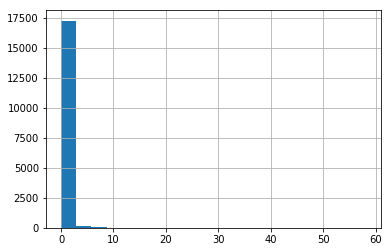

In [25]:
endo_tss_lb.RNA_exp_ave.hist(bins=20)

Actually, we'll just set the range based on the TSS expression for that region, and update when the range changes. We'll see the max and min to be four times greater than the max, just so the arrows don't look huge.

In [26]:
def make_tss_arrow(tss, start, end, threshold=1.03, active_color='#2e6eb7', inactive_color='#e9c65d', width=10, arrow_length=50):
    # grab TSS within start and end
    tss_region = tss[tss.tss_pos.isin(range(start, end))]
    
    # list of lists. Need four quad coordinates: top, bottom, left, right
    # top and bottom are y-coordinates, left and right are x-coordinates
    
    # draw vertical rectangle to indicate TSS position. Above axis indicates positive strand TSS
    # and below axis indicates negative strand. We'll keep it as a list of lists [top, bottom, left, right]
    # and separate into different lists in ColumnDataSource
    quad_coords = []
    
    # draw horizontal segment to connect to arrow, [x0, y0, x1, y1]
    seg_coords = []
    
    # center of triangle is segment endpoint. Set direction of triangle based on strand
    arrow_angle = []
    
    # assign color based on TSS expression above or below threshold
    tss_color = []
    
    for i in range(len(tss_region)):
        
        expn = tss_region.RNA_exp_ave.iloc[i]
        position = tss_region.tss_pos.iloc[i]
        
        if expn < threshold:
            tss_color.append(inactive_color)    
        else:
            tss_color.append(active_color)
        
        if tss_region.strand.iloc[i] == '+':
            # top, bottom, left, right
            quad_coords.append([expn, 0, position, position + width])
            # draw line to the right: x0, y0, x1, y1
            seg_coords.append([position, expn, position + arrow_length, expn])
            arrow_angle.append(-90)
        elif tss_region.strand.iloc[i] == '-':
            quad_coords.append([0, -expn, position, position + width])
            # draw line to the left
            seg_coords.append([position, -expn, position - arrow_length, -expn])
            arrow_angle.append(90)
        else:
            raise Exception('Invalid strand')
    
    src_tss = ColumnDataSource(data=dict(
    top = [quad_coords[i][0] for i in range(len(quad_coords))],
    bottom = [quad_coords[i][1] for i in range(len(quad_coords))],
    left = [quad_coords[i][2] for i in range(len(quad_coords))],
    right = [quad_coords[i][3] for i in range(len(quad_coords))],
    x0 = [seg_coords[i][0] for i in range(len(seg_coords))],
    y0 = [seg_coords[i][1] for i in range(len(seg_coords))],
    x1 = [seg_coords[i][2] for i in range(len(seg_coords))],
    y1 = [seg_coords[i][3] for i in range(len(seg_coords))],
    angle = arrow_angle,
    color = tss_color))
    
    return src_tss
                  

In [27]:
src_tss = make_tss_arrow(endo_tss_lb, start, end)
src_tss.data

{'angle': [-90,
  -90,
  90,
  90,
  -90,
  -90,
  -90,
  90,
  -90,
  90,
  90,
  -90,
  -90,
  90,
  -90,
  90,
  -90,
  90,
  90,
  -90,
  90],
 'bottom': [0,
  0,
  -1.23297703755442,
  -0.35746619449423706,
  0,
  0,
  0,
  -0.38025793775601496,
  0,
  -0.32285192661191103,
  -0.316205530566734,
  0,
  0,
  -0.375471735722201,
  0,
  -3.7733854437345897,
  0,
  -0.361764728520514,
  -0.33240028476491196,
  0,
  -0.40933570132711106],
 'color': ['#e9c65d',
  '#e9c65d',
  '#2e6eb7',
  '#e9c65d',
  '#e9c65d',
  '#2e6eb7',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#2e6eb7',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d',
  '#e9c65d'],
 'left': [451558.0,
  453939.0,
  453431.0,
  454575.0,
  453573.0,
  454217.0,
  450922.0,
  452382.0,
  454058.0,
  452851.0,
  454051.0,
  452678.0,
  454346.0,
  454138.0,
  453647.0,
  450876.0,
  454602.0,
  452908.0,
  452197.0,
  453888.0,
  454259.0],
 'right': [45

In [28]:
# combine everything

def make_region_plot(src, src_gene, src_tss):
    '''
    Construct pileup plot based on src
    '''

    # output_file(html_output)

    # flatten list of lists in count column of src, find max value of absolute expression
    count_range = max(map(abs, [x for count in src.data['count'] for x in count]))
    
    # draw blank figure of correct size with tools
    p = figure(y_range=(-count_range, count_range), plot_width=900, plot_height=700, 
               tools=[BoxSelectTool(), BoxZoomTool(), PanTool(), WheelZoomTool(), 
                      SaveTool(), ResetTool()],
               toolbar_location='above')
    
    # format axis and colors
    p.xaxis.axis_label = 'position'
    p.xaxis.major_label_orientation = pi/4
    p.xaxis[0].formatter.use_scientific = False
    # p.xaxis[0].ticker=FixedTicker(ticks=range(start, end, 100))
    p.yaxis.axis_label = 'log normalized expression (RNA/DNA)'
        
    p.patches(source=src, xs='position', ys='count', fill_color='color', line_color=None, alpha=0.50)

    # plot genes
    p.rect(x='gene_center', y='gene_center_y', width='gene_width',
                 color='gene_color', height=10, height_units='screen', 
                  alpha=0.75, source=src_gene)
    p.triangle(x='tri_x', y=0, size=20, angle='angle', angle_units='deg',
                     fill_color='gene_color', line_color=None, alpha=0.75, source=src_gene)
    p.text(x='gene_center', y='gene_center_y', text='gene_name', text_color='black',
          text_align='center', text_baseline='middle', text_font_size='10pt', source=src_gene)
    
    # add second y-axis for TSS strength
    max_tss = max(map(abs, src_tss.data['y0']))
    p.extra_y_ranges = {'tss' : Range1d(start=-(max_tss * 4), end=(max_tss * 4))}
    p.add_layout(LinearAxis(y_range_name='tss', axis_label='TSS expression'), 'right')
    
    # draw vertical rectangle
    p.quad(top='top', bottom='bottom', left='left', right='right', color='color',
           source=src_tss, y_range_name='tss')
    # draw horizontal line for arrow
    p.segment(x0='x0', y0='y0', x1='x1', y1='y1', color='color',
              source=src_tss, line_width=4,  y_range_name='tss')
    # center of triangle is endpoint of segment
    p.triangle(x='x1', y='y1', size=9, angle='angle', angle_units='deg', color='color', 
               source=src_tss, y_range_name='tss')
    
    return p

In [29]:
p = make_region_plot(src, src_gene, src_tss)
show(p)

In [30]:
global rna_plus
global rna_minus

rna_plus = pd.read_table('B6_M9_2.Forward.wig',
    sep='\t', skiprows=1, names=['position', 'raw_expression'])
rna_minus = pd.read_table('B6_M9_2.Reverse.pos_values.wig',
    sep='\t', skiprows=1, names=['position', 'raw_expression'])
rna_plus.raw_expression.describe()

count    3.195523e+06
mean     2.537179e+03
std      3.448642e+04
min      1.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      2.600000e+01
max      1.980450e+06
Name: raw_expression, dtype: float64

In [31]:
rna_minus.raw_expression.describe()

count    3.260287e+06
mean     6.723781e+02
std      1.297743e+04
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      3.000000e+01
max      7.912540e+05
Name: raw_expression, dtype: float64

In [32]:
np.median(rna_plus.raw_expression)

5.0

In [33]:
np.median(rna_minus.raw_expression)

6.0

In [34]:
# normalize and scale
max_val = 1000
rna_plus = rna_plus.assign(expression = min_max_scale(rna_plus.raw_expression, new_min, new_max, max_value=max_val,
                                                     median_norm=np.median(rna_plus.raw_expression)))
rna_minus = rna_minus.assign(expression = min_max_scale(rna_minus.raw_expression, new_min, new_max, max_value=max_val,
                                                       median_norm=np.median(rna_minus.raw_expression)))

# add condition
rna_plus['condition'] = ['M9'] * len(rna_plus)
rna_minus['condition'] = ['M9'] * len(rna_minus)

rna_plus.head()

,position,raw_expression,expression,condition
0,12,1.0,1.0,M9
1,13,1.0,1.0,M9
2,14,1.0,1.0,M9
3,15,1.0,1.0,M9
4,16,1.0,1.0,M9


In [35]:
rna_minus_subset = rna_minus[(rna_minus.condition.isin(conditions)) &
                                           (rna_minus.position.isin(range(450000, 452000)))]
rna_minus_subset.head()

,position,raw_expression,expression,condition


In [36]:
expn = min_max_scale(rna_minus.raw_expression, new_min, new_max, max_value=max_val)
expression = np.where(rna_minus.raw_expression > 1000, 1000, rna_minus.raw_expression)
norm = (expression - 1) / float(1000 - 1)
norm[289387:289391]

array([0.45645646, 0.43843844, 0.43443443, 0.43343343])

Let's incorporate the RNA data using line graph.

In [37]:
def make_rna_line(start, end, conditions):

    # subset for relevant condition and position
    rna_plus_subset = rna_plus[(rna_plus.condition.isin(conditions)) &
                                           (rna_plus.position.isin(range(start, end)))]
    rna_minus_subset = rna_minus[(rna_minus.condition.isin(conditions)) &
                                           (rna_minus.position.isin(range(start, end)))]
    rna_minus_subset.head()

    # convert expression to log and flip minus expression to negative
    src_rna = ColumnDataSource(data=dict(
    x_plus = rna_plus_subset.position.tolist(),
    y_plus = np.log10(rna_plus_subset.expression.tolist()),
    x_minus = rna_minus_subset.position.tolist(),
    y_minus = -(np.log10(rna_minus_subset.expression.tolist()))))

    return src_rna


In [38]:
conditions = ['M9']
src_rna = make_rna_line(start, end, conditions)

In [39]:
def plot_test(src, src_gene, src_tss, src_rna):
    '''
    Construct pileup plot based on src
    '''

    # output_file(html_output)

    # flatten list of lists in count column of src, find max value of absolute expression
    frag_count_range = max(map(abs, [x for count in src.data['count'] for x in count]))
    rna_count_range = max(max(src_rna.data['y_plus']), max(abs(src_rna.data['y_minus'])))
    count_range = max(frag_count_range, rna_count_range)
    
    # draw blank figure of correct size with tools
    p = figure(y_range=(-count_range, count_range), plot_width=900, plot_height=700, 
               tools=[BoxSelectTool(), BoxZoomTool(), PanTool(), WheelZoomTool(), 
                      SaveTool(), ResetTool()],
               toolbar_location='above')
    
    # format axis and colors
    p.xaxis.axis_label = 'position'
    p.xaxis.major_label_orientation = pi/4
    p.xaxis[0].formatter.use_scientific = False
    # p.xaxis[0].ticker=FixedTicker(ticks=range(start, end, 100))
    p.yaxis.axis_label = 'log normalized expression (RNA/DNA)'
        
    p.patches(source=src, xs='position', ys='count', fill_color='color', line_color=None, alpha=0.50)

    # plot genes
    p.rect(x='gene_center', y='gene_center_y', width='gene_width',
                 color='gene_color', height=10, height_units='screen', 
                  alpha=0.75, source=src_gene)
    p.triangle(x='tri_x', y=0, size=20, angle='angle', angle_units='deg',
                     fill_color='gene_color', line_color=None, alpha=0.75, source=src_gene)
    p.text(x='gene_center', y='gene_center_y', text='gene_name', text_color='black',
          text_align='center', text_baseline='middle', text_font_size='10pt', source=src_gene)
    
    # add second y-axis for TSS strength
    max_tss = max(map(abs, src_tss.data['y0']))
    p.extra_y_ranges = {'tss' : Range1d(start=-(max_tss * 4), end=(max_tss * 4))}
    p.add_layout(LinearAxis(y_range_name='tss', axis_label='TSS expression'), 'right')
    
    # draw vertical rectangle
    p.quad(top='top', bottom='bottom', left='left', right='right', color='color',
           source=src_tss, y_range_name='tss')
    # draw horizontal line for arrow
    p.segment(x0='x0', y0='y0', x1='x1', y1='y1', color='color',
              source=src_tss, line_width=4,  y_range_name='tss')
    # center of triangle is endpoint of segment
    p.triangle(x='x1', y='y1', size=9, angle='angle', angle_units='deg', color='color', 
               source=src_tss, y_range_name='tss')
    
    # draw RNA lines
    if len(src_rna.data['x_minus']) > 0:
        p.line(x='x_plus', y='y_plus', line_color='#528ecb', line_width=2, source=src_rna)
        p.line(x='x_minus', y='y_minus', line_color='#ef8137', line_width=2, source=src_rna)
    
    return p

In [40]:
p = plot_test(src, src_gene, src_tss, src_rna)
show(p)

In [123]:
tmp = make_rna_line(start, end, ['LB'])
tmp.data

{'x_minus': [],
 'x_plus': [],
 'y_minus': array([], dtype=float64),
 'y_plus': array([], dtype=float64)}

In [126]:
if len(src_rna.data['x_minus']) > 0:
    print "foo"

foo


In [43]:
from bokeh.models.widgets import RadioGroup

gene_button = RadioGroup(
    labels=['RegulonDB gene annotation (show)', 'RegulonDB gene annotation (hide)'],
    active=0)

In [46]:
gene_button.active == '0'

False